In [400]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [401]:
# Dataset extract from  https://eu-football.info/_matches.php?id=70&oppo=149

In [402]:
import pandas as pd
import matplotlib.pyplot as plt


get_opponent_name = opponent = "Sweden"

opponent_colors = {
        'Sweden': '#FECC00',    # Sweden (Yellow)
        'Norway': '#EF2B2D',   # Norway (Red)
        'Russia': '#D52B1E',    # Russia (Red)
        'Canada': '#D52B1E',    # Canada (Red)
        'Austria': '#B22234',       # USA (Red)
        'Germany': '#000000',   # Germany (Black)
        'Latvia': '#9E3039',    # Latvia (Red)
        'Czech Republic': '#D7141A',  # Czechia (Red)
        'Slovakia': '#EE1C25',  # Slovakia (Red)
        'Hungary': '#C60C30',   # Hungary (Red)
        'Switzerland': '#FF0000',  # Switzerland (Red)
        'default': '#FECC00'    # Fallback color
}


def analyze_opponent_results(df, opponent=get_opponent_name, year_interval=5):
    """
    Analyze match results against any opponent from a unified dataset
    
    Parameters:
        df (DataFrame): Pandas DataFrame containing all matches
        opponent (str): Opponent country name (default: 'Sweden')
        year_interval (int): Years to group by (default: 5)
    Returns:
        Tuple: (results_df, opponent, year_interval)
    """
    # Create a clean copy of the filtered data to avoid chained assignment
    opponent_matches = df[df['Score'].str.contains(f"vs {opponent}|{opponent} vs", case=False)].copy()
    
    # Perform all assignments on the copy
    opponent_matches.loc[:, 'Year'] = pd.to_datetime(opponent_matches['Date_STD'], format='%d-%m-%Y').dt.year
    opponent_matches.loc[:, 'Period'] = (opponent_matches['Year'] // year_interval) * year_interval
    opponent_matches.loc[:, 'Period_Range'] = (
        opponent_matches['Period'].astype(str) + 
        '-' + 
        (opponent_matches['Period'] + year_interval - 1).astype(str)
    )    # Calculate results
    results = opponent_matches.groupby('Period_Range').agg({
        'Result': [
            ('Total', 'count'),
            ('Wins', lambda x: (x == 'Won').sum()),
            ('Losses', lambda x: (x == 'Lost').sum()),
            ('Draws', lambda x: (x == 'Draw').sum())
        ]
    })
    
    # Flatten multi-index columns
    results.columns = ['_'.join(col).strip() for col in results.columns.values]
    
    # Calculate percentages
    results['Win_Pct'] = (results['Result_Wins'] / results['Result_Total'] * 100).round(1)
    results['Loss_Pct'] = (results['Result_Losses'] / results['Result_Total'] * 100).round(1)
    results['Draw_Pct'] = (results['Result_Draws'] / results['Result_Total'] * 100).round(1)
    
    # Format output
    results_df = results[[
        'Result_Total',
        'Result_Wins', 'Win_Pct',
        'Result_Losses', 'Loss_Pct',
        'Result_Draws', 'Draw_Pct'
    ]].rename(columns={
        'Result_Total': 'Total_Matches',
        'Result_Wins': 'Wins',
        'Result_Losses': 'Losses',
        'Result_Draws': 'Draws'
    })
    
    return results_df, opponent, year_interval

def print_analysis_results(df, opponent, year_interval):
    """Helper function to print formatted results"""
    results, opp, interval = analyze_opponent_results(df, opponent, year_interval)
    print(f"\nFinland vs {opp} ({interval}-year intervals):")
    print(results.to_string())

# Usage example
df = pd.read_csv("datasets/Sports_Football_Finland_Vs_Other.csv")

# Analyze against different opponents
print_analysis_results(df, get_opponent_name, 5)


Finland vs Sweden (5-year intervals):
              Total_Matches  Wins  Win_Pct  Losses  Loss_Pct  Draws  Draw_Pct
Period_Range                                                                 
1910-1914                 3     0     0.00       3    100.00      0      0.00
1915-1919                 2     0     0.00       1     50.00      1     50.00
1920-1924                 6     2    33.30       4     66.70      0      0.00
1925-1929                 5     0     0.00       5    100.00      0      0.00
1930-1934                 6     1    16.70       4     66.70      1     16.70
1935-1939                 6     0     0.00       5     83.30      1     16.70
1940-1944                 3     0     0.00       2     66.70      1     33.30
1945-1949                 6     0     0.00       5     83.30      1     16.70
1950-1954                 8     1    12.50       6     75.00      1     12.50
1955-1959                 6     0     0.00       6    100.00      0      0.00
1960-1964                

<h1 style="line-height:3rem;">Based on the information above, Finland performed better from 2015 to 2019, achieving a winning percentage of approximately 66%, the highest in its 100-year history.</h1>

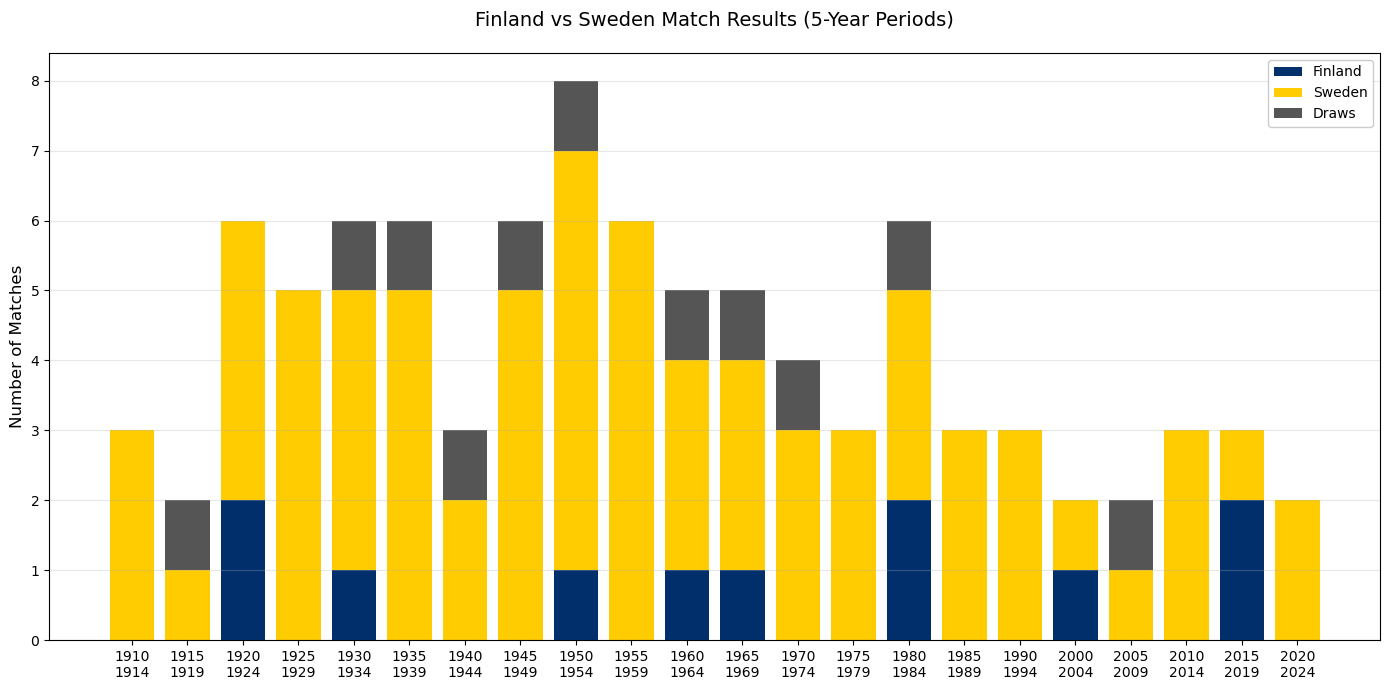

In [404]:
def plot_opponent_results(df, opponent=get_opponent_name, year_interval=5):
    """
    Plot match results with dynamic opponent-based labeling and colors.
    
    Args:
        df (pd.DataFrame): Match results data
        opponent (str): Opponent team name (default: 'Sweden')
        year_interval (int): Number of years per period (default: 5)
    """
    # Define opponent colors (based on national flags)
   
    # Get analysis results
    results, opp, interval = analyze_opponent_results(df, opponent, year_interval)
    
    # Set opponent color (fallback to default if not found)
    opponent_color = opponent_colors.get(opponent, opponent_colors['default'])
    
    # Create figure
    plt.figure(figsize=(14, 7))
    
    # Dynamic bar labels
    win_label = 'Finland'
    loss_label = opponent
    draw_label = 'Draws'
    
    # Create stacked bars with dynamic colors
    plt.bar(results.index, results['Wins'], 
            color='#002F6C', label=win_label)  # Finland (Blue)
    plt.bar(results.index, results['Losses'], 
            bottom=results['Wins'], 
            color=opponent_color, label=loss_label)  # Opponent (Dynamic)
    plt.bar(results.index, results['Draws'], 
            bottom=results['Wins'] + results['Losses'], 
            color='#555555', label=draw_label)  # Draws (Gray)
    
    # Two-line x-axis labels
    x_labels = [f"{p.split('-')[0]}\n{p.split('-')[1]}" for p in results.index]
    plt.xticks(range(len(results)), x_labels)
    
    # Dynamic title and labels
    plt.title(f'Finland vs {opponent} Match Results ({year_interval}-Year Periods)', 
              pad=20, fontsize=14)
    plt.ylabel('Number of Matches', fontsize=12)
    
    plt.legend(loc='upper right', framealpha=1)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

# Example usage:
plot_opponent_results(df, get_opponent_name, 5)  # Norway's losses will be red

# Analysis of matches against Sweden

Finland vs Sweden (5-year periods):


,Finland_Total,Finland_Avg,Matches,Opponent_Total,Opponent_Avg,Opponent_Matches,Goal_Diff,Avg_Diff
Period_Label,,,,,,,,
1910-1914,6,2.00,3,16,5.33,3,10,3.33
1915-1919,3,1.50,2,4,2.00,2,1,0.50
1920-1924,14,2.33,6,20,3.33,6,6,1.00
1925-1929,7,1.40,5,19,3.80,5,12,2.40
1930-1934,13,2.17,6,28,4.67,6,15,2.50
1935-1939,6,1.00,6,19,3.17,6,13,2.17
1940-1944,3,1.00,3,9,3.00,3,6,2.00
1945-1949,6,1.00,6,37,6.17,6,31,5.17
1950-1954,10,1.25,8,36,4.50,8,26,3.25


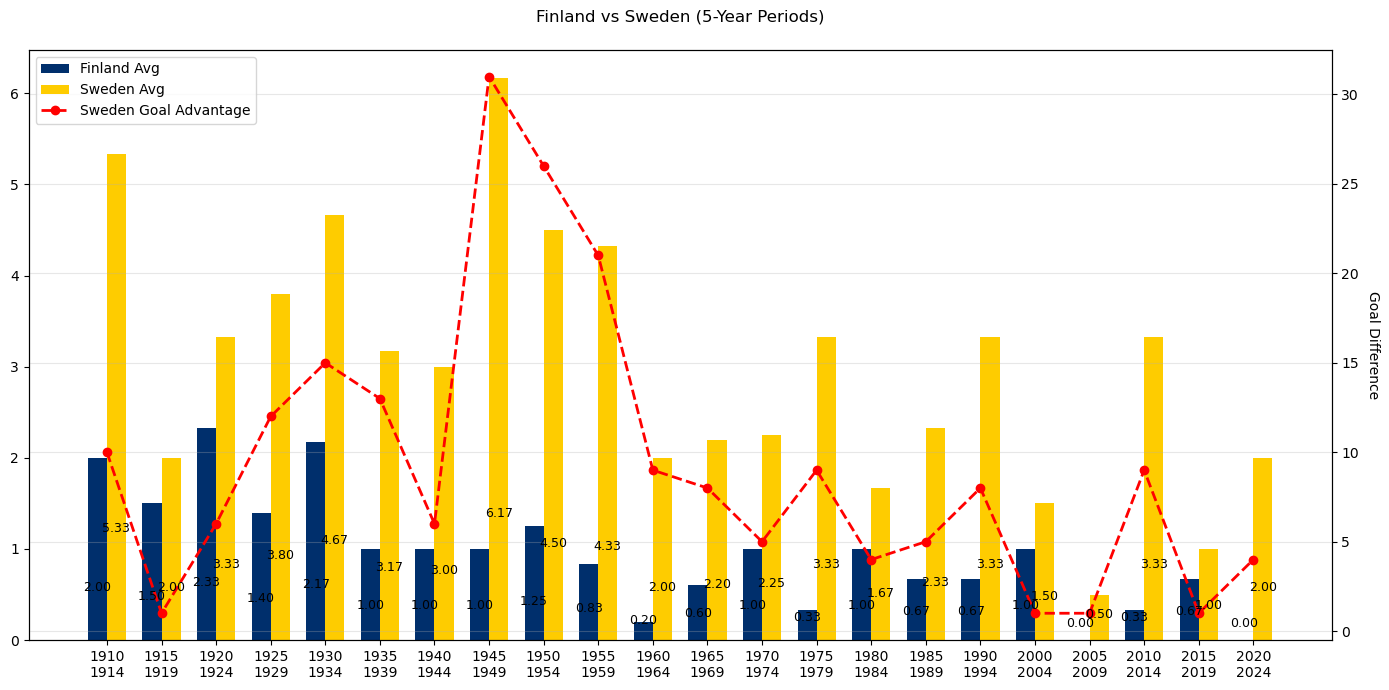

In [406]:

def extract_goals(score_str):
    """Extract goals from Score column"""
    parts = score_str.split()
    goals = parts[0].split('-')
    if "Finland vs" in score_str:
        return int(goals[0]), int(goals[1])  # Finland, Opponent
    else:
        return int(goals[1]), int(goals[0])  # Opponent, Finland

def analyze_opponent_results(df, opponent=get_opponent_name, year_interval=5):
    """Analyze match results with proper DataFrame handling"""
    # Create clean copy and extract goals
    df_clean = df.copy()
    df_clean[['Finland_Goals', 'Opponent_Goals']] = (
        df_clean['Score'].apply(lambda x: pd.Series(extract_goals(x)))
    )
    
    # Filter matches and create period columns safely
    opponent_matches = df_clean[
        df_clean['Score'].str.contains(f'vs {opponent}|{opponent} vs', case=False)
    ].copy()
    
    # Calculate periods using .loc to avoid warnings
    opponent_matches.loc[:, 'Year'] = pd.to_datetime(
        opponent_matches['Date_STD'], format='%d-%m-%Y'
    ).dt.year
    opponent_matches.loc[:, 'Period_Start'] = (
        opponent_matches['Year'] // year_interval
    ) * year_interval
    opponent_matches.loc[:, 'Period_End'] = (
        opponent_matches['Period_Start'] + year_interval - 1
    )
    opponent_matches.loc[:, 'Period_Label'] = (
        opponent_matches['Period_Start'].astype(str) + '-' + 
        opponent_matches['Period_End'].astype(str)
    )
    
    # Group and analyze
    period_stats = opponent_matches.groupby('Period_Label').agg({
        'Finland_Goals': ['sum', lambda x: round(x.mean(), 2), 'count'],
        'Opponent_Goals': ['sum', lambda x: round(x.mean(), 2), 'count']
    })
    
    # Format results
    period_stats.columns = [
        'Finland_Total', 'Finland_Avg', 'Matches',
        'Opponent_Total', 'Opponent_Avg', 'Opponent_Matches'
    ]
    period_stats['Goal_Diff'] = period_stats['Opponent_Total'] - period_stats['Finland_Total']
    period_stats['Avg_Diff'] = round(period_stats['Opponent_Avg'] - period_stats['Finland_Avg'], 2)
    
    return period_stats, opponent, year_interval






def plot_results(period_stats, opponent, year_interval):
    """Visualize results with dynamic opponent colors and two-line year labels"""
    # Define opponent colors (national flag colors)
   
    # Get opponent color (fallback to default if not found)
    opponent_color = opponent_colors.get(opponent, opponent_colors['default'])
    
    plt.figure(figsize=(14, 7))
    x = np.arange(len(period_stats))
    width = 0.35
    
    # Create bars with dynamic opponent color
    finland_bars = plt.bar(
        x - width/2, 
        period_stats['Finland_Avg'], 
        width,
        label='Finland Avg', 
        color='#002F6C'  # Finland blue
    )
    opponent_bars = plt.bar(
        x + width/2, 
        period_stats['Opponent_Avg'], 
        width,
        label=f'{opponent} Avg', 
        color=opponent_color  # Dynamic color
    )
    
    # Goal difference line (red dashed)
    ax2 = plt.gca().twinx()
    diff_line = ax2.plot(
        x, period_stats['Goal_Diff'], 
        'r--o',
        label=f'{opponent} Goal Advantage', 
        linewidth=2
    )
    
    # Add value labels
    for i in x:
        plt.text(
            i - width/2, 
            period_stats.iloc[i]['Finland_Avg'] + 0.05,
            f"{period_stats.iloc[i]['Finland_Avg']:.2f}",
            ha='center', 
            va='bottom', 
            fontsize=9
        )
        plt.text(
            i + width/2, 
            period_stats.iloc[i]['Opponent_Avg'] + 0.05,
            f"{period_stats.iloc[i]['Opponent_Avg']:.2f}",
            ha='center', 
            va='bottom', 
            fontsize=9
        )
    
    # Format plot
    plt.title(f'Finland vs {opponent} ({year_interval}-Year Periods)', pad=20)
    plt.xticks(x, [f"{p.split('-')[0]}\n{p.split('-')[1]}" for p in period_stats.index])
    plt.xlabel('Time Period')
    plt.ylabel('Average Goals')
    ax2.set_ylabel('Goal Difference', rotation=270, labelpad=15)
    
    # Combine legends
    lines = [finland_bars, opponent_bars, diff_line[0]]
    plt.legend(lines, [l.get_label() for l in lines], loc='upper left')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

# Example usage
df = pd.read_csv("datasets/Sports_Football_Finland_Vs_Other.csv")

# Analyze and plot
stats, opponent, interval = analyze_opponent_results(df, get_opponent_name, 5)
print(f"Finland vs {opponent} ({interval}-year periods):")
display(stats)
plot_results(stats, opponent, interval)

# Average Goal By per Match

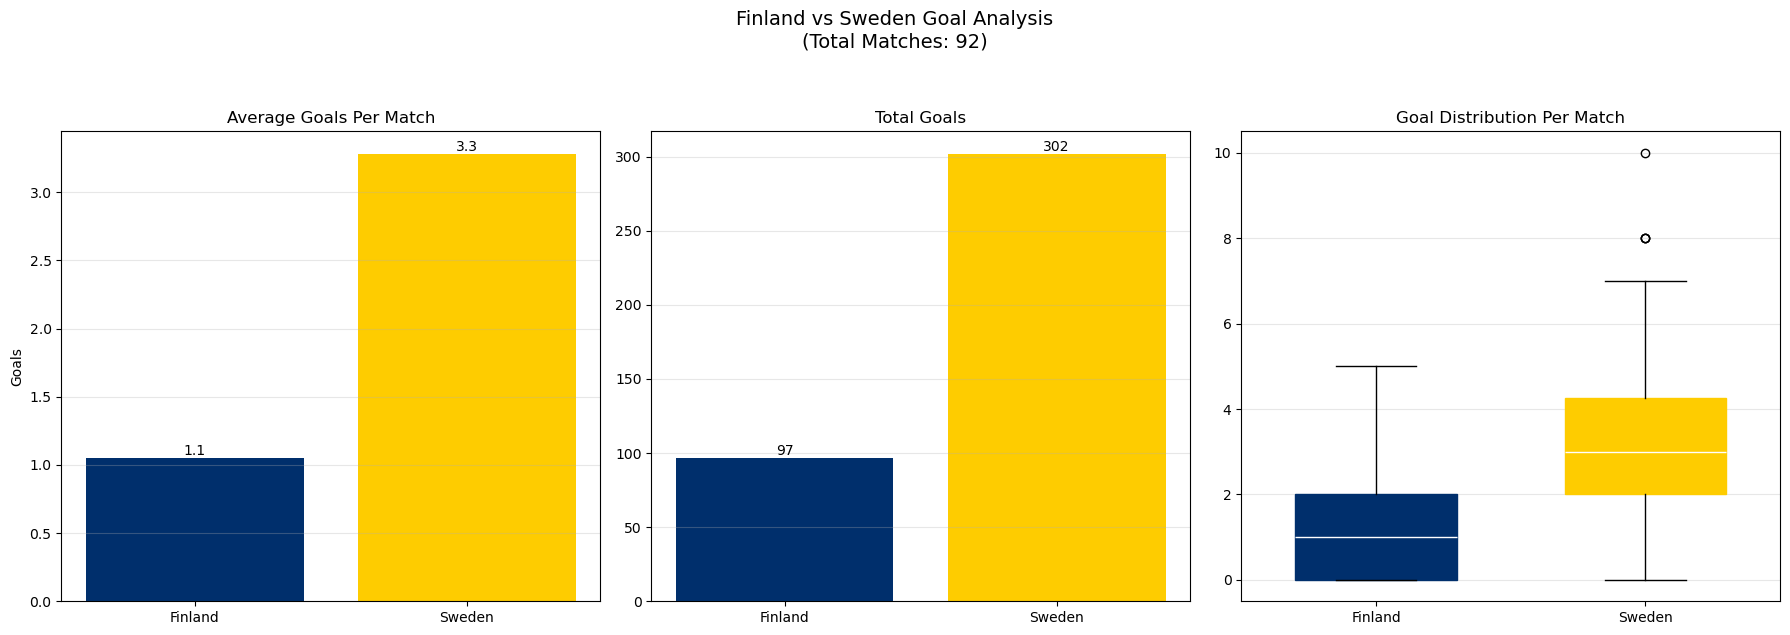

In [408]:

def plot_comprehensive_goals(df, opponent=get_opponent_name):
    """
    Plot a comprehensive comparison including:
    - Average goals (bar plot)
    - Total goals (bar plot) 
    - Goal distribution (boxplot)
    """
    # Filter matches and extract goals
    opponent_matches = df[
        df['Score'].str.contains(f'vs {opponent}|{opponent} vs', case=False)
    ].copy()
    
    opponent_matches[['Finland_Goals', 'Opponent_Goals']] = (
        opponent_matches['Score'].apply(lambda x: pd.Series(extract_goals(x)))
    )
    
    # Calculate statistics
    finland_avg = opponent_matches['Finland_Goals'].mean()
    opponent_avg = opponent_matches['Opponent_Goals'].mean()
    finland_total = opponent_matches['Finland_Goals'].sum()
    opponent_total = opponent_matches['Opponent_Goals'].sum()
    total_matches = len(opponent_matches)
    
    # Set up colors
    opponent_colors = {
        'Sweden': '#FECC00',   # Yellow
        'Norway': '#EF2B2D',   # Red
        'default': '#555555'   # Gray
    }
    opponent_color = opponent_colors.get(opponent, opponent_colors['default'])
    
    # Create figure with subplots
    fig = plt.figure(figsize=(18, 6))
    gs = fig.add_gridspec(1, 3)
    
    # Plot 1: Average Goals
    ax1 = fig.add_subplot(gs[0, 0])
    bars1 = ax1.bar(
        ['Finland', opponent],
        [finland_avg, opponent_avg],
        color=['#002F6C', opponent_color]
    )
    ax1.set_title('Average Goals Per Match')
    ax1.set_ylabel('Goals')
    ax1.grid(axis='y', alpha=0.3)
    
    # Plot 2: Total Goals
    ax2 = fig.add_subplot(gs[0, 1])
    bars2 = ax2.bar(
        ['Finland', opponent],
        [finland_total, opponent_total],
        color=['#002F6C', opponent_color]
    )
    ax2.set_title('Total Goals')
    ax2.grid(axis='y', alpha=0.3)
    
    # Plot 3: Goal Distribution (Boxplot)
    ax3 = fig.add_subplot(gs[0, 2])
    boxprops = {
        'facecolor': '#002F6C',
        'color': '#002F6C'
    }
    opponent_boxprops = {
        'facecolor': opponent_color,
        'color': opponent_color
    }
    
    # Create boxplots side by side
    positions = [1, 2]
    b1 = ax3.boxplot(
        opponent_matches['Finland_Goals'],
        positions=[positions[0]],
        widths=0.6,
        patch_artist=True,
        boxprops=boxprops,
        medianprops={'color': 'white'}
    )
    b2 = ax3.boxplot(
        opponent_matches['Opponent_Goals'],
        positions=[positions[1]],
        widths=0.6,
        patch_artist=True,
        boxprops=opponent_boxprops,
        medianprops={'color': 'white'}
    )
    
    ax3.set_title('Goal Distribution Per Match')
    ax3.set_xticks(positions)
    ax3.set_xticklabels(['Finland', opponent])
    ax3.grid(axis='y', alpha=0.3)
    
    # Add value labels to bar plots
    for bars, ax in zip([bars1, bars2], [ax1, ax2]):
        for bar in bars:
            height = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width()/2, height,
                f'{height:.1f}' if ax == ax1 else f'{int(height)}',
                ha='center', va='bottom'
            )
    
    # Main title
    fig.suptitle(
        f'Finland vs {opponent} Goal Analysis\n(Total Matches: {total_matches})',
        fontsize=14,
        y=1.05
    )
    
    plt.tight_layout()
    plt.show()

# Example usage
plot_comprehensive_goals(df, get_opponent_name)  # Sweden analysis

# Finland Defense Status

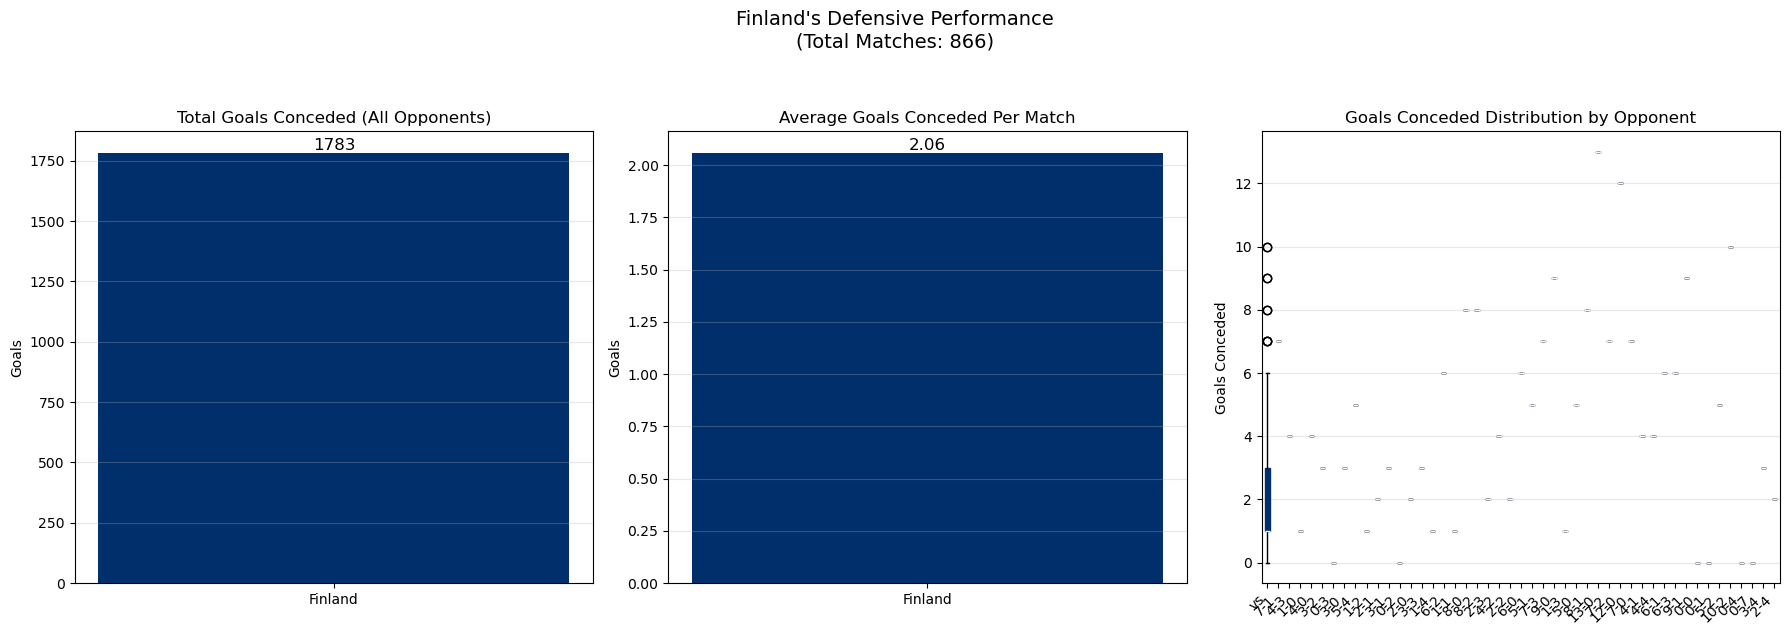

In [419]:
def plot_finland_defensive_stats(df):
    """
    Plot Finland's defensive performance against all opponents:
    - Total goals conceded
    - Average goals conceded per match
    - Distribution of goals conceded (boxplot)
    """
    # Extract goals conceded by Finland from all matches
    df[['Finland_Goals', 'Opponent_Goals', 'Is_Home', 'Opponent']] = (
        df['Score'].apply(lambda x: pd.Series(extract_goals_and_teams(x)))
    )
    # Calculate defensive statistics
    total_conceded = df['Opponent_Goals'].sum()
    avg_conceded = df['Opponent_Goals'].mean()
    matches_played = len(df)
    
    # Create figure
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    
    # Plot 1: Total Goals Conceded
    ax1.bar(['Finland'], [total_conceded], color='#002F6C')
    ax1.set_title('Total Goals Conceded (All Opponents)')
    ax1.set_ylabel('Goals')
    ax1.text(0, total_conceded, f'{int(total_conceded)}', 
             ha='center', va='bottom', fontsize=12)
    ax1.grid(axis='y', alpha=0.3)
    
    # Plot 2: Average Goals Conceded
    ax2.bar(['Finland'], [avg_conceded], color='#002F6C')
    ax2.set_title('Average Goals Conceded Per Match')
    ax2.set_ylabel('Goals')
    ax2.text(0, avg_conceded, f'{avg_conceded:.2f}', 
             ha='center', va='bottom', fontsize=12)
    ax2.grid(axis='y', alpha=0.3)
    
    # Plot 3: Goals Conceded Distribution by Opponent
    box_data = []
    opponents = []
    for opponent in df['Opponent'].unique():
        goals = df[df['Opponent'] == opponent]['Opponent_Goals']
        if len(goals) > 0:  # Only include opponents with matches
            box_data.append(goals)
            opponents.append(opponent)
    
    ax3.boxplot(box_data, patch_artist=True,
                boxprops=dict(facecolor='#002F6C', color='#002F6C'),
                medianprops=dict(color='white'))
    ax3.set_title('Goals Conceded Distribution by Opponent')
    ax3.set_xticks(range(1, len(opponents)+1))
    ax3.set_xticklabels(opponents, rotation=45, ha='right')
    ax3.set_ylabel('Goals Conceded')
    ax3.grid(axis='y', alpha=0.3)
    
    # Main title
    fig.suptitle(
        f"Finland's Defensive Performance\n(Total Matches: {matches_played})",
        fontsize=14,
        y=1.05
    )
    
    plt.tight_layout()
    plt.show()

# Example usage
plot_finland_defensive_stats(df)

# Finland offensive (Attack) Status


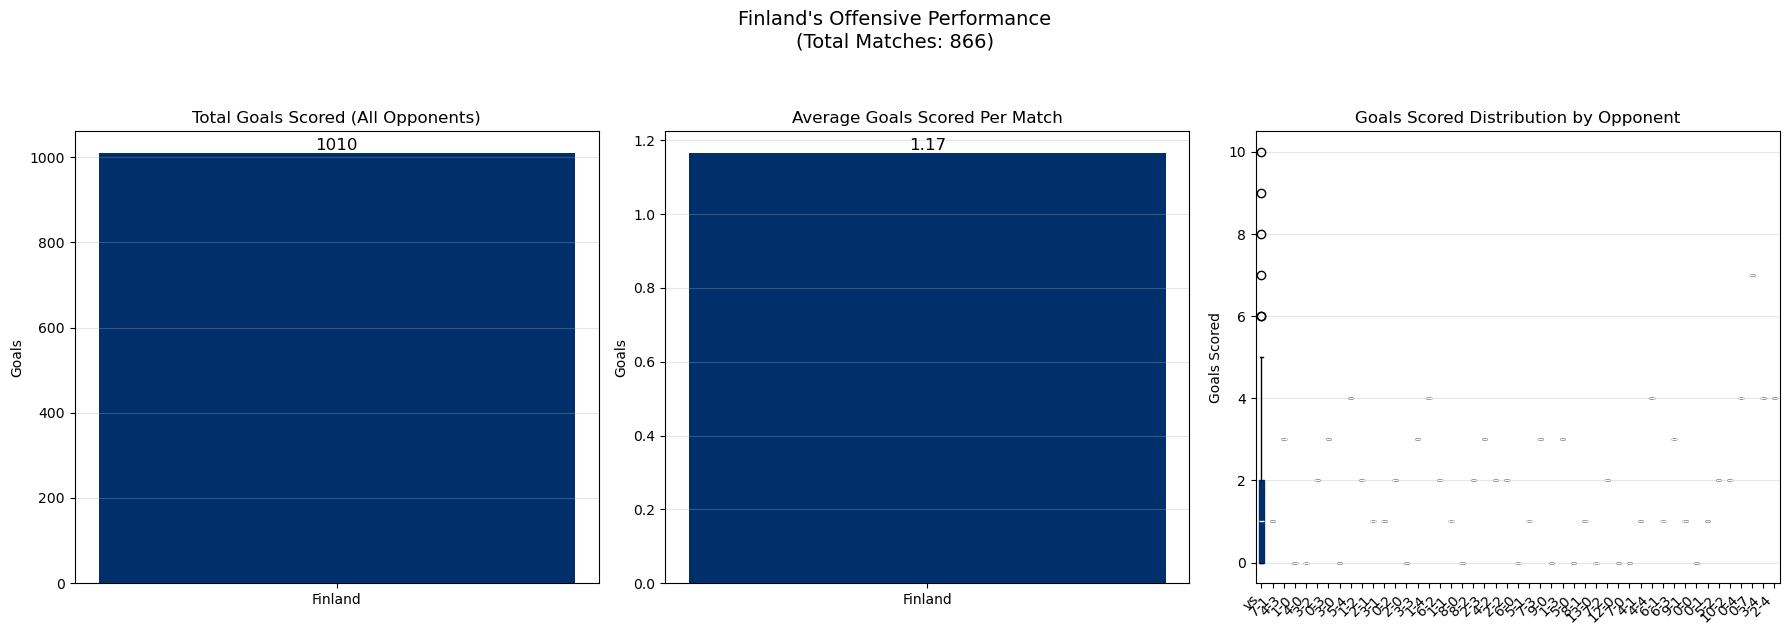


Key Statistics:
• Total goals scored: 1010
• Average per match: 1.17
• Matches analyzed: 866


In [423]:
def plot_finland_offensive_stats(df):
    """
    Plot Finland's offensive performance against all opponents:
    - Total goals scored
    - Average goals scored per match
    - Distribution of goals scored (boxplot)
    """
    # Extract goals scored by Finland from all matches
    df[['Finland_Goals', 'Opponent_Goals', 'Is_Home', 'Opponent']] = (
        df['Score'].apply(lambda x: pd.Series(extract_goals_and_teams(x)))
    )
    # Calculate offensive statistics
    total_scored = df['Finland_Goals'].sum()
    avg_scored = df['Finland_Goals'].mean()
    matches_played = len(df)
    
    # Create figure
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    
    # Plot 1: Total Goals Scored
    ax1.bar(['Finland'], [total_scored], color='#002F6C')
    ax1.set_title('Total Goals Scored (All Opponents)')
    ax1.set_ylabel('Goals')
    ax1.text(0, total_scored, f'{int(total_scored)}', 
             ha='center', va='bottom', fontsize=12)
    ax1.grid(axis='y', alpha=0.3)
    
    # Plot 2: Average Goals Scored
    ax2.bar(['Finland'], [avg_scored], color='#002F6C')
    ax2.set_title('Average Goals Scored Per Match')
    ax2.set_ylabel('Goals')
    ax2.text(0, avg_scored, f'{avg_scored:.2f}', 
             ha='center', va='bottom', fontsize=12)
    ax2.grid(axis='y', alpha=0.3)
    
    # Plot 3: Goals Scored Distribution by Opponent
    box_data = []
    opponents = []
    for opponent in df['Opponent'].unique():
        goals = df[df['Opponent'] == opponent]['Finland_Goals']
        if len(goals) > 0:  # Only include opponents with matches
            box_data.append(goals)
            opponents.append(opponent)
    
    ax3.boxplot(box_data, patch_artist=True,
                boxprops=dict(facecolor='#002F6C', color='#002F6C'),
                medianprops=dict(color='white'))
    ax3.set_title('Goals Scored Distribution by Opponent')
    ax3.set_xticks(range(1, len(opponents)+1))
    ax3.set_xticklabels(opponents, rotation=45, ha='right')
    ax3.set_ylabel('Goals Scored')
    ax3.grid(axis='y', alpha=0.3)
    
    # Main title
    fig.suptitle(
        f"Finland's Offensive Performance\n(Total Matches: {matches_played})",
        fontsize=14,
        y=1.05
    )
    
    plt.tight_layout()
    plt.show()

    # Return key statistics
    return {
        'total_goals_scored': total_scored,
        'average_goals_per_match': avg_scored,
        'matches_analyzed': matches_played
    }

# Example usage
offensive_stats = plot_finland_offensive_stats(df)
print(f"\nKey Statistics:")
print(f"• Total goals scored: {offensive_stats['total_goals_scored']}")
print(f"• Average per match: {offensive_stats['average_goals_per_match']:.2f}")
print(f"• Matches analyzed: {offensive_stats['matches_analyzed']}")

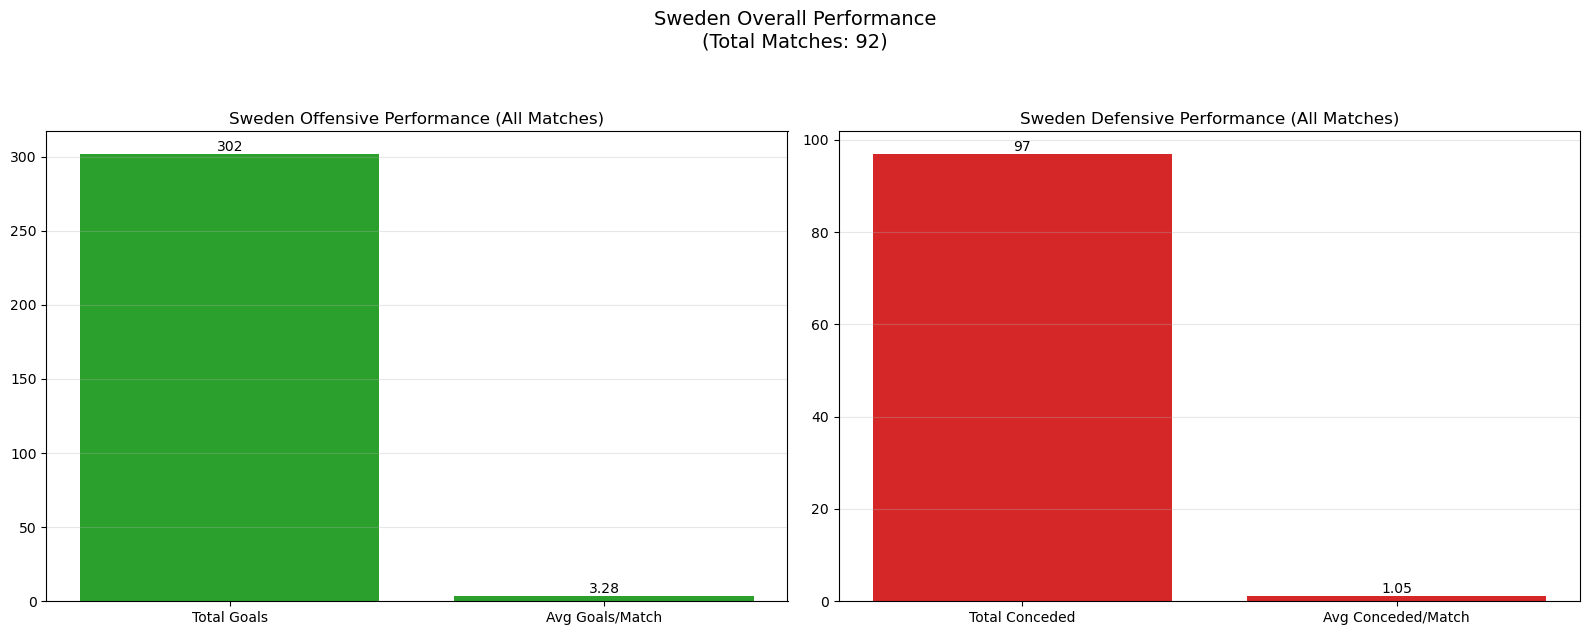

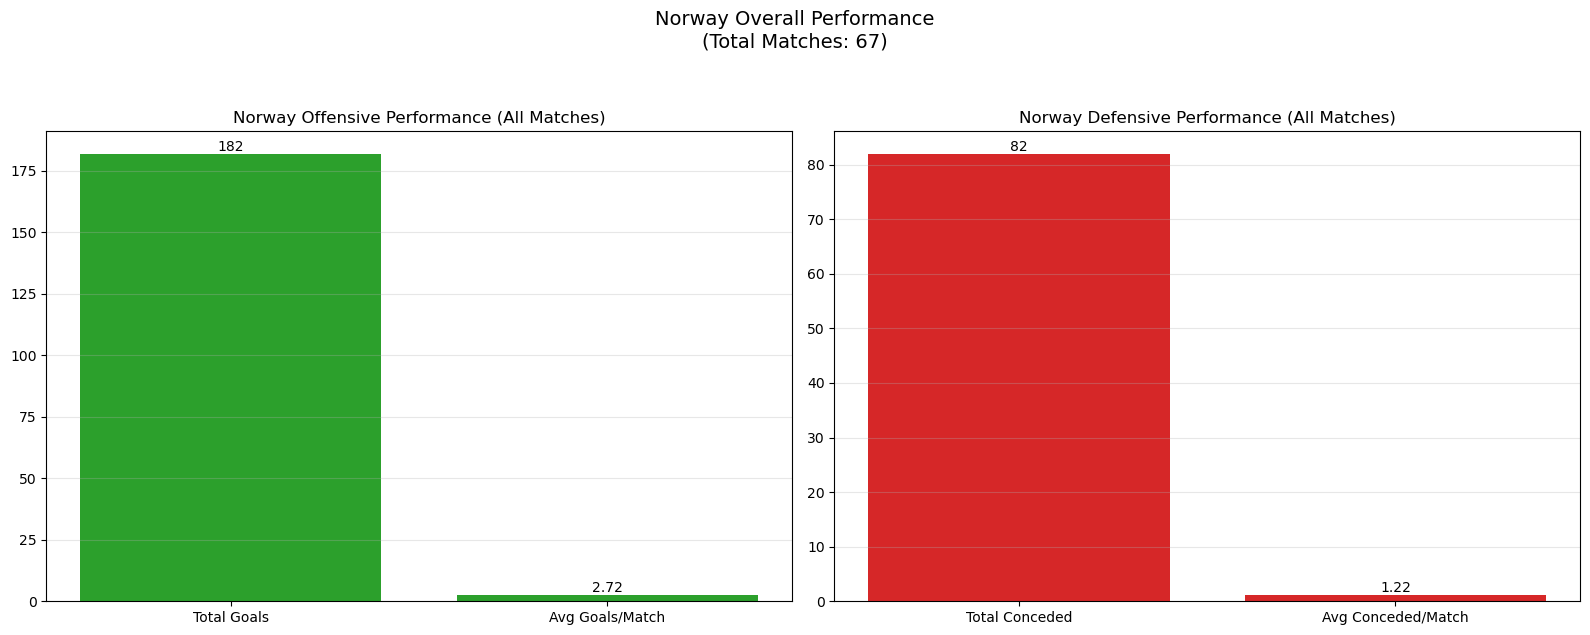


Sweden Overall Performance:
• Total Matches: 92
• Goals Scored: 302 (Avg: 3.28/match)
• Goals Conceded: 97 (Avg: 1.05/match)
• Win Rate: 76.1%
• Draw Rate: 12.0%

Norway Overall Performance:
• Total Matches: 67
• Goals Scored: 182 (Avg: 2.72/match)
• Goals Conceded: 82 (Avg: 1.22/match)
• Win Rate: 61.2%
• Draw Rate: 25.4%


In [430]:
def analyze_team_performance_general(df, team_name):
    """
    Analyze a team's overall offensive and defensive performance in all matches
    Returns: Dictionary with key metrics and visualizations
    """
    # Find all matches where the team appears (either as home or away)
    team_matches = df[
        df['Score'].str.contains(f'{team_name} vs|vs {team_name}', case=False)
    ].copy()
    
    if team_matches.empty:
        print(f"No matches found for {team_name}")
        return None
    
    # Extract goals for each match
    def extract_team_goals(row):
        parts = row['Score'].split()
        goals = list(map(int, parts[0].split('-')))
        if parts[1] == team_name:
            return pd.Series([goals[0], goals[1]])  # Team goals, Opponent goals
        else:
            return pd.Series([goals[1], goals[0]])  # Team goals, Opponent goals
    
    team_matches[['Team_Goals', 'Opponent_Goals']] = team_matches.apply(extract_team_goals, axis=1)
    
    # Calculate metrics
    stats = {
        'team': team_name,
        'total_matches': len(team_matches),
        # Offensive stats
        'total_goals_scored': team_matches['Team_Goals'].sum(),
        'avg_goals_scored': team_matches['Team_Goals'].mean(),
        # Defensive stats
        'total_goals_conceded': team_matches['Opponent_Goals'].sum(),
        'avg_goals_conceded': team_matches['Opponent_Goals'].mean(),
        'win_rate': (team_matches['Team_Goals'] > team_matches['Opponent_Goals']).mean(),
        'draw_rate': (team_matches['Team_Goals'] == team_matches['Opponent_Goals']).mean()
    }
    
    # Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Offensive Performance
    ax1.bar(['Total Goals', 'Avg Goals/Match'], 
            [stats['total_goals_scored'], stats['avg_goals_scored']], 
            color='#2ca02c')  # Green for offense
    ax1.set_title(f'{team_name} Offensive Performance (All Matches)')
    ax1.grid(axis='y', alpha=0.3)
    
    # Defensive Performance
    ax2.bar(['Total Conceded', 'Avg Conceded/Match'], 
            [stats['total_goals_conceded'], stats['avg_goals_conceded']], 
            color='#d62728')  # Red for defense
    ax2.set_title(f'{team_name} Defensive Performance (All Matches)')
    ax2.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for ax in [ax1, ax2]:
        for bar in ax.patches:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, height,
                    f'{height:.2f}' if height < 10 else f'{int(height)}',
                    ha='center', va='bottom')
    
    plt.suptitle(f"{team_name} Overall Performance\n(Total Matches: {stats['total_matches']})", 
                fontsize=14, y=1.05)
    plt.tight_layout()
    plt.show()
    
    return stats

# Example usage
sweden_stats = analyze_team_performance_general(df, "Sweden")
norway_stats = analyze_team_performance_general(df, "Norway")

# Print detailed stats
def print_general_stats(stats):
    print(f"\n{stats['team']} Overall Performance:")
    print(f"• Total Matches: {stats['total_matches']}")
    print(f"• Goals Scored: {stats['total_goals_scored']} (Avg: {stats['avg_goals_scored']:.2f}/match)")
    print(f"• Goals Conceded: {stats['total_goals_conceded']} (Avg: {stats['avg_goals_conceded']:.2f}/match)")
    print(f"• Win Rate: {stats['win_rate']:.1%}")
    print(f"• Draw Rate: {stats['draw_rate']:.1%}")

if sweden_stats:
    print_general_stats(sweden_stats)
if norway_stats:
    print_general_stats(norway_stats)